In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import zipfile

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirnames)} directories and {len(filenames)} in {dirpath} directory')

--2022-11-25 15:23:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.5MB/s    in 4.5s    

2022-11-25 15:23:59 (35.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

there are 2 directories and 0 in 10_food_classes_10_percent directory
there are 10 directories and 0 in 10_food_classes_10_percent/train directory
there are 0 directories and 75 in 10_food_classes_10_percent/train/steak directory
there are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_wings directory
there are 0 directories and 75 in 10_food_

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical',
                                               target_size = IMAGE_SHAPE)
test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical',
                                               target_size = IMAGE_SHAPE)



Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
#Create tensorboard callback

import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name +'/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  return tensorboard_callback



In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

def create_model(url,num_classes):
  model = tf.keras.Sequential([
      hub.KerasLayer(url,
                    trainable=False,
                     name = 'feature_extraction_layer',
                     input_shape = IMAGE_SHAPE + (3,)),  # Can be True, see below.
      layers.Dense(num_classes, activation='softmax', name = 'output_layer')
  ])
  return model

model_1 = create_model(efficientnet,10)
model_2 = create_model(resnet,10)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
model_1 = create_model(efficientnet,10)
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
hisotry_1 = model_1.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data, callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'resnet50V2')])

Epoch 1/10
24/24 [==============================] - 34s 1s/step - loss: 1.8437 - accuracy: 0.4360 - val_loss: 1.3029 - val_accuracy: 0.7304
Epoch 2/10
24/24 [==============================] - 16s 698ms/step - loss: 1.0557 - accuracy: 0.7893 - val_loss: 0.8672 - val_accuracy: 0.8240
Epoch 3/10
24/24 [==============================] - 16s 695ms/step - loss: 0.7490 - accuracy: 0.8440 - val_loss: 0.6954 - val_accuracy: 0.8536
Epoch 4/10
24/24 [==============================] - 16s 669ms/step - loss: 0.5987 - accuracy: 0.8787 - val_loss: 0.6100 - val_accuracy: 0.8648
Epoch 5/10
24/24 [==============================] - 16s 684ms/step - loss: 0.5080 - accuracy: 0.8960 - val_loss: 0.5577 - val_accuracy: 0.8732
Epoch 6/10
24/24 [==============================] - 16s 683ms/step - loss: 0.4422 - accuracy: 0.9040 - val_loss: 0.5201 - val_accuracy: 0.8784
Epoch 7/10
24/24 [==============================] - 16s 670ms/step - loss: 0.3873 - accuracy: 0.9293 - val_loss: 0.4915 - val_accuracy: 0.8792
Ep

In [ ]:
import itertools
def plot_loss_curves(history):
  history_pd = pd.DataFrame(history.history)
  loss = history_pd['loss']
  accuracy = history_pd['accuracy']
  val_loss = history_pd['val_loss']
  val_accuracy = history_pd['val_accuracy']
  fig,ax = plt.subplots(2, 2)
  fig.set_size_inches(25, 20)
  for i, j in itertools.product(range(2), range(2)):
    ax[i,j].set_xlabel('epochs')
  ax[0,0].plot(loss)
  ax[0,0].set_title('loss')
  ax[0,1].plot(accuracy)
  ax[0,1].set_title('accuracy')
  ax[1,0].plot(val_loss)
  ax[1,0].set_title('val_loss')
  ax[1,1].plot(val_accuracy)
  ax[1,1].set_title('val_accuracy')
  plt.show()

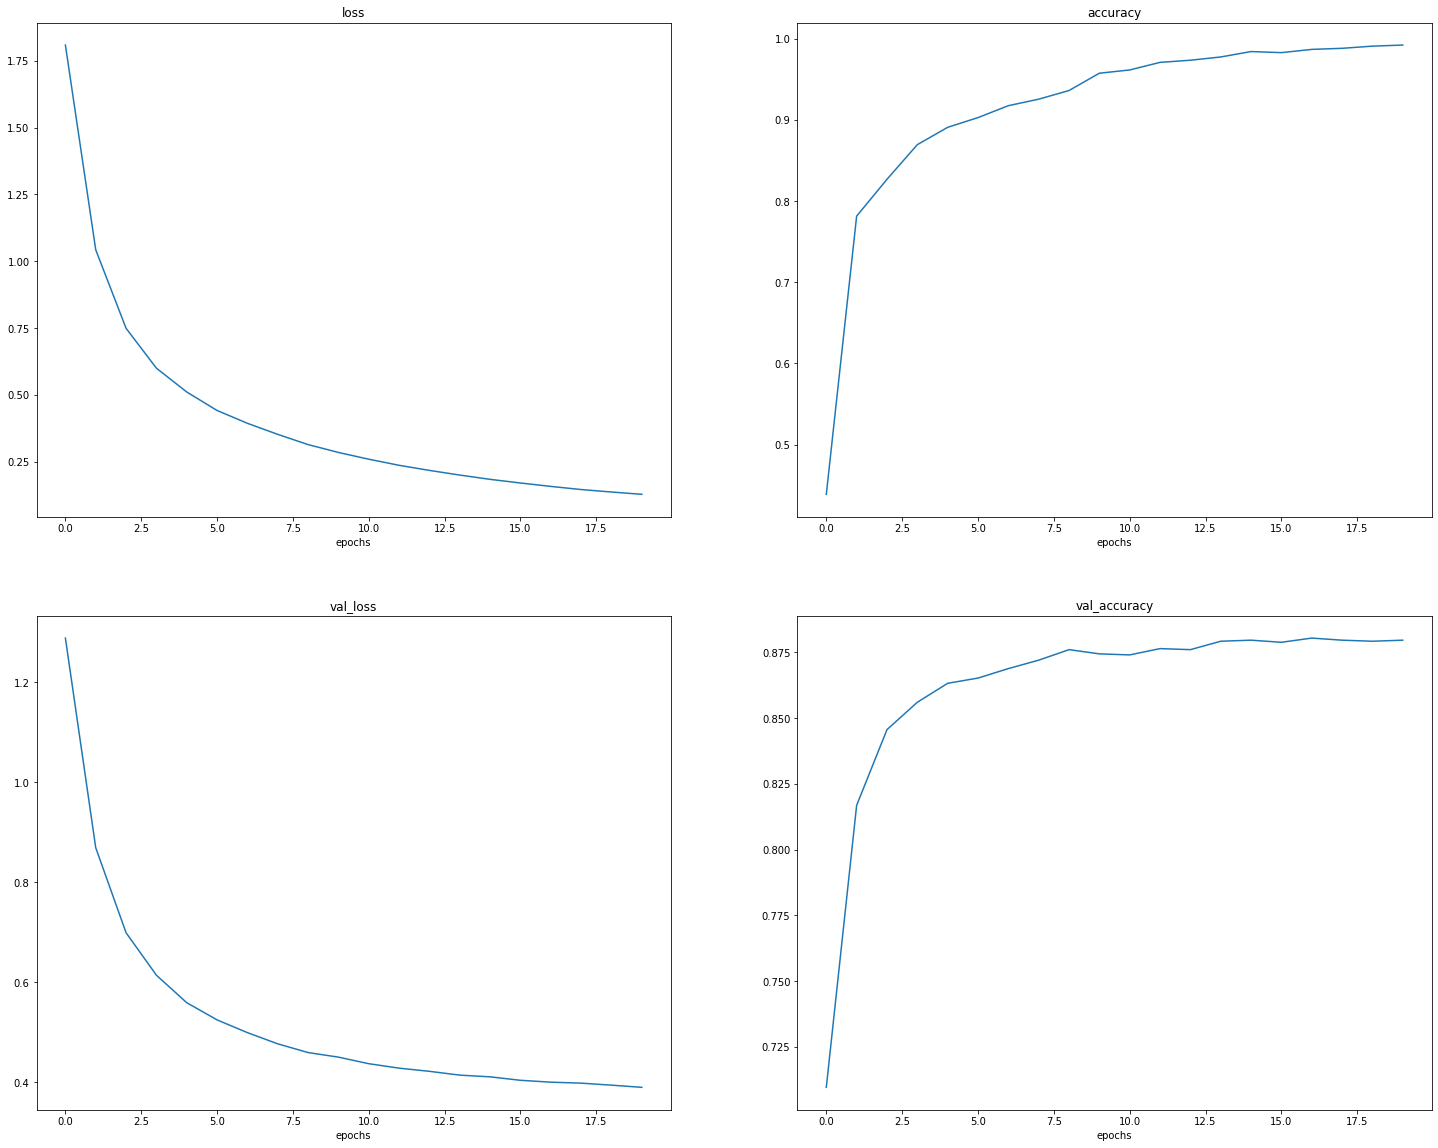

In [ ]:
plot_loss_curves(hisotry_1)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
hisotry_2 = model_2.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data, callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'efficient_net')])

Epoch 1/10
24/24 [==============================] - 23s 794ms/step - loss: 1.9906 - accuracy: 0.3533 - val_loss: 1.2200 - val_accuracy: 0.6140
Epoch 2/10
24/24 [==============================] - 17s 712ms/step - loss: 0.9192 - accuracy: 0.7373 - val_loss: 0.8701 - val_accuracy: 0.7196
Epoch 3/10
24/24 [==============================] - 17s 717ms/step - loss: 0.6155 - accuracy: 0.8373 - val_loss: 0.7505 - val_accuracy: 0.7592
Epoch 4/10
24/24 [==============================] - 17s 715ms/step - loss: 0.4704 - accuracy: 0.8867 - val_loss: 0.7297 - val_accuracy: 0.7592
Epoch 5/10
24/24 [==============================] - 17s 719ms/step - loss: 0.3758 - accuracy: 0.9147 - val_loss: 0.6842 - val_accuracy: 0.7744
Epoch 6/10
24/24 [==============================] - 20s 850ms/step - loss: 0.3131 - accuracy: 0.9347 - val_loss: 0.6573 - val_accuracy: 0.7808
Epoch 7/10
24/24 [==============================] - 17s 742ms/step - loss: 0.2593 - accuracy: 0.9507 - val_loss: 0.6321 - val_accuracy: 0.7896

In [ ]:
! tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Efficientnet vs resnet"\
  --description "Comparing models"\
  --one_shot 


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/lRQFmyp0QHywJ2miLxASpw/

[2022-11-25T16:08:34] Started scanning logdir.
[2022-11-25T16:08:43] Total uploaded: 306 scalars, 0 tensors, 5 binary objects (14.9 MB)
[2022-11-25T16:08:43] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/lRQFmyp0QHywJ2miLxASpw/


In [ ]:
!tensorboard dev list
#delete experiment
#!tensorboard dev delete --experiment_id /copyid/


https://tensorboard.dev/experiment/UM40fEsEQWq8eQqiBBsGBA/
	Name                 Efficientnet vs resnet
	Description          Comparing models
	Id                   UM40fEsEQWq8eQqiBBsGBA
	Created              2022-11-25 15:34:55 (12 minutes ago)
	Updated              2022-11-25 15:34:59 (12 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  5793947
Total: 1 experiment(s)


In [ ]:
image_net = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'
model_3 = create_model(image_net,10)
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
history_3 = model_3.fit(train_data,epochs= 10, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = len(test_data),callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'Image_Net')])

Epoch 1/10
24/24 [==============================] - 21s 725ms/step - loss: 1.9109 - accuracy: 0.3547 - val_loss: 1.2776 - val_accuracy: 0.6080
Epoch 2/10
24/24 [==============================] - 18s 776ms/step - loss: 1.0358 - accuracy: 0.7093 - val_loss: 0.8870 - val_accuracy: 0.7424
Epoch 3/10
24/24 [==============================] - 17s 713ms/step - loss: 0.7613 - accuracy: 0.7840 - val_loss: 0.7585 - val_accuracy: 0.7744
Epoch 4/10
24/24 [==============================] - 16s 697ms/step - loss: 0.6036 - accuracy: 0.8387 - val_loss: 0.6904 - val_accuracy: 0.7884
Epoch 5/10
24/24 [==============================] - 16s 697ms/step - loss: 0.5064 - accuracy: 0.8720 - val_loss: 0.6459 - val_accuracy: 0.7976
Epoch 6/10
24/24 [==============================] - 16s 686ms/step - loss: 0.4311 - accuracy: 0.9013 - val_loss: 0.6218 - val_accuracy: 0.8012
Epoch 7/10
24/24 [==============================] - 16s 697ms/step - loss: 0.3703 - accuracy: 0.9280 - val_loss: 0.6027 - val_accuracy: 0.8080

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                        rotation_range=0.2,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2)
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'categorical',
                                               target_size = IMAGE_SHAPE)


Found 750 images belonging to 10 classes.


In [ ]:
model_4 = create_model(efficientnet,10)
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
hisotry_4 = model_4.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data, callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'efficient_net_with_augmentation')])

Epoch 1/10
24/24 [==============================] - 32s 984ms/step - loss: 1.8497 - accuracy: 0.4480 - val_loss: 1.3282 - val_accuracy: 0.6900
Epoch 2/10
24/24 [==============================] - 23s 965ms/step - loss: 1.1862 - accuracy: 0.7027 - val_loss: 0.9316 - val_accuracy: 0.7776
Epoch 3/10
24/24 [==============================] - 23s 950ms/step - loss: 0.9012 - accuracy: 0.7760 - val_loss: 0.7510 - val_accuracy: 0.8200
Epoch 4/10
24/24 [==============================] - 22s 940ms/step - loss: 0.7342 - accuracy: 0.8280 - val_loss: 0.6558 - val_accuracy: 0.8368
Epoch 5/10
24/24 [==============================] - 22s 945ms/step - loss: 0.6586 - accuracy: 0.8333 - val_loss: 0.5992 - val_accuracy: 0.8488
Epoch 6/10
24/24 [==============================] - 22s 949ms/step - loss: 0.5870 - accuracy: 0.8413 - val_loss: 0.5524 - val_accuracy: 0.8568
Epoch 7/10
24/24 [==============================] - 22s 956ms/step - loss: 0.5297 - accuracy: 0.8707 - val_loss: 0.5281 - val_accuracy: 0.8584